In [1]:
#import libraries
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.externals import joblib

/home/kaijuri/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# process the image
digits extraction from image

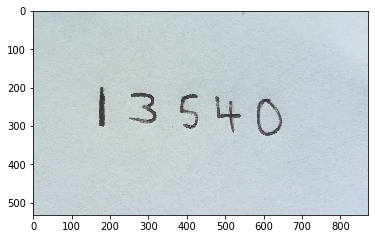

In [18]:
img=cv2.imread("/home/kaijuri/Desktop/vision photos/numbers.jpg") #image load
plt.imshow(img)

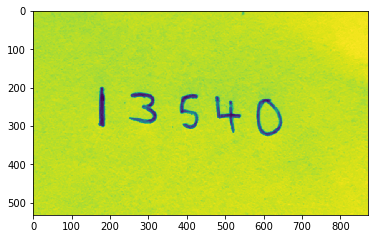

In [3]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blurred=cv2.GaussianBlur(gray,(5,5),0)               #noise removal
plt.imshow(blurred)

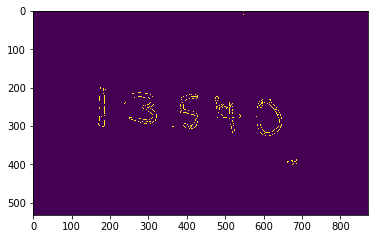

In [4]:
#extract the edges from the gray images by using canny edge dection algo
edge=cv2.Canny(blurred,4,70)
plt.imshow(edge)                           

In [5]:
#useful functions
def x_cord_contours(contours):
    '''
    for locating the x cordinate using cnetroid
    '''
    if cv2.contourArea(contours)>10:
        M=cv2.moments(contours)
        return (int(M['m10']/M['m00']))
    
def makesquare(not_square):
    '''
    making a single digit image into a square by adding some blackborder
    '''
    black=[0,0,0]
    img_dim=not_square.shape
    height=img_dim[0]
    width=img_dim[1]
    
    if (height==width):
        square=not_square
        return square
    else:
        dsize=(2*width,2*height)
        doublesize=cv2.resize(not_square,dsize,interpolation=cv2.INTER_CUBIC)
        height=(2*height)
        width=(2*width)
        
        
        if height>width:
            pad=int((height-width)/2)
            doublesize_square=cv2.copyMakeBorder(doublesize,0,0,pad,
                                                 pad,cv2.BORDER_CONSTANT,value=black)
                                                 
        else:
            pad=int((width-height)/2)
            doublesize_square=cv2.copyMakeBorder(doublesize,pad,pad,0,0,
                                                 cv2.BORDER_CONSTANT,value=black)
    return doublesize_square 

def sort_contours(contours):
    '''
    for filter the contours,we don't want small area contours
    '''
    new_contour=[]
    for cnt in contours:
        if cv2.contourArea(cnt)>10:
            new_contour.append(cnt)
    return new_contour        

def resize_to_pixel(dimensions,image):
    '''
    making the image to required size
    '''
    buffer_pix=4
    dimensions=dimensions-buffer_pix
    squared=image
    r=float(dimensions)/squared.shape[1]
    dim=(dimensions,int(squared.shape[0]*r))
    resized=cv2.resize(image,dim,interpolation=cv2.INTER_AREA)
    img_dim2=resized.shape
    height_r=img_dim2[0]
    width_r=img_dim2[1]
    black=[0,0,0]
    if height_r>width_r:
        resized=cv2.copyMakeBorder(resized,0,0,0,1,cv2.BORDER_CONSTANT,value=black)
    if width_r>height_r:    
        resized=cv2.copyMakeBorder(resized,1,0,0,0,cv2.BORDER_CONSTANT,value=black)
    p=2
    resizedimg=resized=cv2.copyMakeBorder(resized,p,p,p,p,cv2.BORDER_CONSTANT,value=black)
    return resizedimg

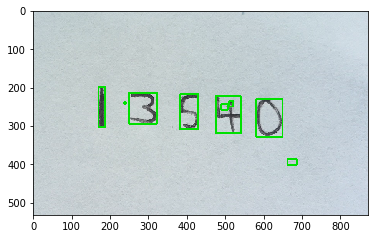

In [6]:
# extract the contours form the image
contours,hierarchy=cv2.findContours(edge.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #find contours
new_contours=sort_contours(contours)  #sortcontours
sort_contour=sorted(new_contours,key=x_cord_contours,reverse=False)

#check the contours(test)
for c in new_contours:
    x,y,w,h=cv2.boundingRect(c)
    ip=cv2.rectangle(img,(x,y),(x+w,y+h),(0,225,0),3)
plt.imshow(ip)    

In [19]:
#preidct the digits image by by our model,by KNN
knn=joblib.load(open('/home/kaijuri/Desktop/knn_model.pkl','rb'))

full_number=[]
for c in sort_contour:
    x,y,w,h=cv2.boundingRect(c)
    
    if w>=5 and h>=25:
        roi=blurred[y:y+h,x:x+w]
        ret,roi=cv2.threshold(roi,127,255,cv2.THRESH_BINARY_INV)
        square=makesquare(roi)
        final=resize_to_pixel(28,square)
        final_array=final.reshape(1,784)
        #cv2.imshow("final",final)
        number=model.predict(final_array)
        full_number.append(number)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        cv2.putText(img,str(*number),(x,y+155),cv2.FONT_HERSHEY_COMPLEX,2,(255,0,0),2)
        cv2.imshow("image",img)
        cv2.waitKey(0)
cv2.destroyAllWindows()        



In [ ]:
#preidct the digits image by by our model ,by neural net
model=load_model("/home/kaijuri/Desktop/deep_digits.h5")
full_number=[]
for c in sort_contour:
    x,y,w,h=cv2.boundingRect(c)
    
    if w>=5 and h>=25:
        roi=blurred[y:y+h,x:x+w]
        ret,roi=cv2.threshold(roi,127,255,cv2.THRESH_BINARY_INV)
        square=makesquare(roi)
        final=resize_to_pixel(28,square)
        final_array=final.reshape(1,28,28,1)
        #cv2.imshow("final",final)
        number=str(model.predict_classes(final_array,1,verbose=0)[0])
        full_number.append(number)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        cv2.putText(img,str(*number),(x,y+155),cv2.FONT_HERSHEY_COMPLEX,2,(255,0,0),2)
        cv2.imshow("image",img)
        cv2.waitKey(0)
cv2.destroyAllWindows()        
    

In [20]:
#for deployment purpose
class prepocess:
    def preprocess_by_knn(image):
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        blurred=cv2.GaussianBlur(gray,(5,5),0)               #noise removal
        edge=cv2.Canny(blurred,4,70)               #edge detection

        contours,hierarchy=cv2.findContours(edge.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #find contours
        new_contours=sort_contours(contours)
        sort_contour=sorted(new_contours,key=x_cord_contours,reverse=False)

        full_number=[]
        for c in sort_contour:
            x,y,w,h=cv2.boundingRect(c)

            if w>=5 and h>=25:
                roi=blurred[y:y+h,x:x+w]
                ret,roi=cv2.threshold(roi,127,255,cv2.THRESH_BINARY_INV)
                square=makesquare(roi)
                final=resize_to_pixel(28,square)
                final_array=final.reshape((1,784))
                number=knn.predict(final_array)
                full_number+=(str(*number))
                #cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
                #cv2.putText(img,str(*number),(x,y+155),cv2.FONT_HERSHEY_COMPLEX,2,(255,0,0),2)

        return "".join(full_number)

    def preprocess_NN(image):
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        blurred=cv2.GaussianBlur(gray,(5,5),0)               #noise removal
        edge=cv2.Canny(blurred,4,70)               #edge detection

        contours,hierarchy=cv2.findContours(edge.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #find contours
        new_contours=sort_contours(contours)
        sort_contour=sorted(new_contours,key=x_cord_contours,reverse=False)

        full_number=[]
        for c in sort_contour:
            x,y,w,h=cv2.boundingRect(c)

            if w>=5 and h>=25:
                roi=blurred[y:y+h,x:x+w]
                ret,roi=cv2.threshold(roi,127,255,cv2.THRESH_BINARY_INV)
                square=makesquare(roi)
                final=resize_to_pixel(28,square)
                final_array=final.reshape((1,28,28,1))
                number=str(model.predict_classes(final_array,1,verbose=0)[0])
                full_number+=(str(*number))
                #cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
                #cv2.putText(img,str(*number),(x,y+155),cv2.FONT_HERSHEY_COMPLEX,2,(255,0,0),2)

        return "".join(full_number)





# testing and live checking

## live handwritten digit app

In [21]:
import gradio as gr

In [22]:
def classify(image):
    im=image.reshape((1,784))
    prediction=knn.predict(im).tolist()[0]
    return prediction
sketchpad=gr.inputs.Sketchpad()
label=gr.outputs.Label(num_top_classes=3)
interface=gr.Interface(classify,sketchpad,label,live=True,capture_session=True)
interface.launch()

Running locally at: http://127.0.0.1:7867/


(<gradio.networking.serve_files_in_background.<locals>.HTTPServer at 0x7fa96c95ea50>,
 'http://127.0.0.1:7867/',
 None)

In [24]:
#by knn
def image_classify(image):
    prediction=preprocess_by_knn(image)
    return prediction
image1= gr.inputs.Image(shape=(299, 299, 3))
label=gr.outputs.Label(num_top_classes=3)
interface=gr.Interface(image_classify,image1,label)
interface.launch()

Running locally at: http://127.0.0.1:7869/


(<gradio.networking.serve_files_in_background.<locals>.HTTPServer at 0x7fa8fe591590>,
 'http://127.0.0.1:7869/',
 None)

In [25]:
#by neural net
def image_classify(image):
    prediction=preprocess_NN(image)
    return prediction
image1= gr.inputs.Image(shape=(299, 299, 3))
label=gr.outputs.Label(num_top_classes=3)
interface=gr.Interface(image_classify,image1,label)
interface.launch()

Running locally at: http://127.0.0.1:7870/


(<gradio.networking.serve_files_in_background.<locals>.HTTPServer at 0x7fa8fe581110>,
 'http://127.0.0.1:7870/',
 None)